In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import keras
from skimage.filters import gabor_kernel
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("tf")
from skimage.color import rgb2gray
from scipy import ndimage as ndi
 
# Import Tensorflow with multiprocessing
import tensorflow as tf
import multiprocessing as mp
 
# Loading the CIFAR-10 datasets
from keras.datasets import cifar10

Using TensorFlow backend.


In [66]:
import cv2
from cv2.cv2 import CV_64F

In [68]:
# def custom_gabor(shape, dtype=None):
#     orientation_spread = np.linspace(0, 4, 8) / 4. * np.pi
#     scales = np.linspace(0.1, 0.4, 6)
#     kernels = []
# #     size, sigma, theta, lambda, gamma aspect ratio
#     for orientation in orientation_spread:
#         for scale in scales:
#             kernel = cv2.getGaborKernel((32, 32), 3, orientation, scale, 1)
#             kernel = np.delete(np.delete(kernel, -1, 0), -1, 1)
#             kernels.append(kernel)
#             break
#         break
#     result = np.array(kernels)
#     return K.variable(result, dtype=dtype)
def custom_gabor(shape, dtype=None):
    total_ker = []
    print(shape)
    for i in range(shape[0]):
        kernels = []
        for j in range(shape[1]):
            # gk = gabor_kernel(frequency=0.2, bandwidth=0.1)
            tmp_filter = cv2.getGaborKernel(ksize=(shape[1] + 1, shape[2] + 1), sigma=1, theta=1, lambd=0.5, gamma=0.3, psi=(3.14) * 0.5, ktype=CV_64F)
            filter = []
            for row in tmp_filter:
                filter.append(np.delete(row, -1))
            kernels.append(filter)
                # gk.real
        total_ker.append(kernels)
    # np_tot = shared(np.array(total_ker))
    return K.variable(np.array(total_ker), dtype=dtype)

In [4]:
batch_size = 32
# 32 examples in a mini-batch, smaller batch size means more updates in one epoch
num_classes = 10
epochs = 24
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
# np.save('x_train', x_train)
# np.save('x_test', x_test)
# np.save('y_train', y_train)
# np.save('y_test', y_test)

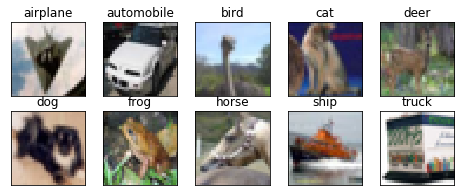

In [5]:
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [6]:
sampling = 100
x_train = x_train.astype('float32')[:sampling]
y_train = np_utils.to_categorical(y_train[:sampling], num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

In [64]:
def base_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',kernel_initializer=custom_gabor, data_format='channels_last', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    # sgd = SGD(lr = 0.1, decay = 1e-6, momentum=0.9, nesterov=True)
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    # Train model
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [71]:
print(x_train.shape[1:])

cnn_n = base_model()
cnn_n.summary()
cnn = cnn_n.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True)

(32, 32, 3)
(3, 3, 3, 32)


ValueError: number of input channels does not match corresponding dimension of filter, 3 != 5

# Evaluation

In [19]:
score = cnn_n.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.317440252304077
Test accuracy: 0.1452


In [34]:
cnn_n.layers[0].get_weights()

[array([[[[ 7.94014186e-02, -8.28367323e-02,  2.38526035e-02,
            1.30937889e-01, -6.87754527e-02,  6.79341778e-02,
            5.79265766e-02, -7.73922950e-02, -8.18545073e-02,
           -1.35723695e-01,  1.09091662e-02, -1.24489568e-01,
            4.74924743e-02, -1.32916421e-01,  1.70715211e-03,
           -4.77390736e-02,  6.02557417e-03, -3.41339484e-02,
           -1.35244429e-01,  9.35593769e-02,  4.31593284e-02,
           -3.75675745e-02,  4.17997018e-02, -6.94170743e-02,
           -1.30752966e-01,  2.18010787e-03, -6.45729946e-03,
            9.26817432e-02, -3.71976122e-02,  5.78029118e-02,
            1.02551095e-01, -1.14410967e-02],
          [ 4.00257893e-02,  1.04805067e-01,  7.21655339e-02,
           -2.63077561e-02,  7.92360306e-03,  3.79013829e-02,
           -1.15899973e-01,  4.96438034e-02, -1.40402382e-02,
           -1.14001349e-01,  5.43889143e-02, -1.73515305e-02,
           -2.87651643e-02, -5.45422137e-02,  1.19921481e-02,
           -1.41702883e-

In [ ]:
# Plots for training and testing process: loss and accuracy

plt.figure(0)
plt.plot(cnn.history['acc'],'r')
plt.plot(cnn.history['val_acc'],'g')
plt.xticks(np.arange(0, epochs, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])


plt.figure(1)
plt.plot(cnn.history['loss'],'r')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, epochs, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])


plt.show()